In [1]:
# Imports
import os
import yaml
import torch
import pandas as pd
import numpy as np
import xarray as xr
import torch.nn as nn

import seqpro as sp
import seqmodels as sm
import seqdata as sd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Report cuda availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [3]:
# Change working directory
os.chdir("/cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/bin/2_train_models")

In [4]:
# Set seed
np.random.seed(1234)

# Data

In [5]:
path_data = "/cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/processed/HSPC.libA.DATA.tsv"

In [6]:
data = pd.read_csv(path_data, sep="\t")

In [7]:
# Upper case
data["seq"] = data["Seq"].str.upper()

In [8]:
# create xarray from pandas, with dimension named '_sequence
sdata = xr.Dataset.from_dataframe(data)
sdata = sdata.rename({'index': '_sequence'})
sdata

<xarray.Dataset>
Dimensions:      (_sequence: 8492)
Coordinates:
  * _sequence    (_sequence) int64 0 1 2 3 4 5 ... 8486 8487 8488 8489 8490 8491
Data variables: (12/14)
    CRS          (_sequence) object 'LibA.Seq1' 'LibA.Seq10' ... 'LibA.Seq9988'
    Seq          (_sequence) object 'aggaccggatcaactgctattgtggaacacataaatttca...
    nrepeats     (_sequence) int64 1 1 4 4 4 4 4 4 5 5 5 ... 4 4 4 4 5 4 5 4 6 6
    affinitynum  (_sequence) float64 1.0 0.8938 0.25 0.5 ... 0.8938 0.25 0.1
    spacer       (_sequence) int64 4 4 4 4 10 20 4 10 ... 10 4 10 20 4 10 20 4
    orientation  (_sequence) object 'fwd' 'rev' 'rev' ... 'tandem' 'tandem'
    ...           ...
    State_3E     (_sequence) float64 -0.0473 0.1464 0.3151 ... 0.06312 -0.03689
    State_4M     (_sequence) float64 -0.08173 0.1509 nan -0.0874 ... nan nan nan
    State_5M     (_sequence) float64 nan nan nan nan nan ... nan nan nan nan nan
    State_6N     (_sequence) float64 -0.196 0.1906 nan -0.1387 ... nan nan nan
    State_7M     (_sequence) float64 nan nan nan nan nan ... nan nan nan nan nan
    seq          (_sequence) object 'AGGACCGGATCAACTGCTATTGTGGAACACATAAATTTCA...

In [9]:
# Create a single target variable to predict
sdata["target"] = sdata["State_3E"]
sdata

<xarray.Dataset>
Dimensions:      (_sequence: 8492)
Coordinates:
  * _sequence    (_sequence) int64 0 1 2 3 4 5 ... 8486 8487 8488 8489 8490 8491
Data variables: (12/15)
    CRS          (_sequence) object 'LibA.Seq1' 'LibA.Seq10' ... 'LibA.Seq9988'
    Seq          (_sequence) object 'aggaccggatcaactgctattgtggaacacataaatttca...
    nrepeats     (_sequence) int64 1 1 4 4 4 4 4 4 5 5 5 ... 4 4 4 4 5 4 5 4 6 6
    affinitynum  (_sequence) float64 1.0 0.8938 0.25 0.5 ... 0.8938 0.25 0.1
    spacer       (_sequence) int64 4 4 4 4 10 20 4 10 ... 10 4 10 20 4 10 20 4
    orientation  (_sequence) object 'fwd' 'rev' 'rev' ... 'tandem' 'tandem'
    ...           ...
    State_4M     (_sequence) float64 -0.08173 0.1509 nan -0.0874 ... nan nan nan
    State_5M     (_sequence) float64 nan nan nan nan nan ... nan nan nan nan nan
    State_6N     (_sequence) float64 -0.196 0.1906 nan -0.1387 ... nan nan nan
    State_7M     (_sequence) float64 nan nan nan nan nan ... nan nan nan nan nan
    seq          (_sequence) object 'AGGACCGGATCAACTGCTATTGTGGAACACATAAATTTCA...
    target       (_sequence) float64 -0.0473 0.1464 0.3151 ... 0.06312 -0.03689

In [10]:
# Ohe
sdata["ohe_seq"] = xr.DataArray(sp.ohe(sdata["seq"].values, alphabet=sp.DNA), dims=["_sequence", "_length", "_alphabet"]).transpose("_sequence", "_alphabet", "_length")

In [11]:
# Grab some test seqs
test_seqs = torch.tensor(sdata["ohe_seq"][:10].values, dtype=torch.float32)
test_dict = {"ohe_seq": test_seqs}

# Architecture

In [12]:
from ResidualBind import ResidualBind
from eugene.models import zoo

In [13]:
# Load model architecture
arch = zoo.ResidualBind(input_len=262, output_dim=1)
arch, arch(test_seqs).shape

(ResidualBind(
   (conv1d_tower): Conv1DTower(
     (layers): Sequential(
       (0): Conv1d(4, 96, kernel_size=(11,), stride=(1,), padding=valid)
       (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
       (3): Dropout(p=0.1, inplace=False)
     )
   )
   (residual_block): Residual(
     (wrapped): Conv1DTower(
       (layers): Sequential(
         (0): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=same)
         (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU()
         (3): Dropout(p=0.1, inplace=False)
         (4): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
         (5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (6): ReLU()
         (7): Dropout(p=0.1, inplace=False)
         (8): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
         (9): BatchNorm1d(96,

# Training module

In [14]:
from seqmodels import Module

In [15]:
# Create module for training
module = Module(
    arch=arch,
    input_vars=["ohe_seq"],
    output_vars=["output"],
    target_vars=["target"],
    squeeze_output=True,
    loss_fxn="mse",
    train_metrics_fxn=["r2", "pearson", "spearman"],
    val_metrics_fxn=["r2", "pearson", "spearman"],
    scheduler="reduce_lr_on_plateau",
)
module, module(test_dict).shape

(Module(
   (arch): ResidualBind(
     (conv1d_tower): Conv1DTower(
       (layers): Sequential(
         (0): Conv1d(4, 96, kernel_size=(11,), stride=(1,), padding=valid)
         (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU()
         (3): Dropout(p=0.1, inplace=False)
       )
     )
     (residual_block): Residual(
       (wrapped): Conv1DTower(
         (layers): Sequential(
           (0): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=same)
           (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU()
           (3): Dropout(p=0.1, inplace=False)
           (4): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
           (5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (6): ReLU()
           (7): Dropout(p=0.1, inplace=False)
           (8): Conv1d(96, 96, kernel_size=(3,), stride=(1,),

In [16]:
module(test_dict)

tensor([[-0.3266],
        [-0.4092],
        [-0.5464],
        [-0.2164],
        [-0.3449],
        [-0.7074],
        [-0.2086],
        [ 0.4033],
        [ 0.3989],
        [-0.2904]], grad_fn=<MmBackward0>)

# DataLoaders

In [17]:
# Randomly split the data
def split_xarray(
    data: xr.Dataset, frac: float = 0.8, shuffle: bool = True
) -> xr.Dataset:
    if shuffle:
        idx = np.random.permutation(data["_sequence"])
        data = data.sel(_sequence=idx)
    split_idx = int(frac * data.dims["_sequence"])
    train_data = data.sel(_sequence=data["_sequence"][:split_idx])
    val_data = data.sel(_sequence=data["_sequence"][split_idx:])
    return train_data, val_data

In [18]:
train_sdata, valid_sdata = split_xarray(sdata, frac=0.8)
train_sdata.dims["_sequence"], valid_sdata.dims["_sequence"]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


(6793, 1699)

In [19]:
# Drop Nan values from target
train_sdata = train_sdata.dropna(dim="_sequence", subset=["target"])
train_sdata

<xarray.Dataset>
Dimensions:      (_sequence: 6792, _alphabet: 4, _length: 262)
Coordinates:
  * _sequence    (_sequence) int64 1277 5763 6044 7344 ... 4589 578 7085 4572
Dimensions without coordinates: _alphabet, _length
Data variables: (12/16)
    CRS          (_sequence) object 'LibA.Seq2464' ... 'LibA.Seq6656'
    Seq          (_sequence) object 'aggaccggatcaactgtgaggggcgataagtttcctacat...
    nrepeats     (_sequence) int64 3 5 5 2 4 4 6 1 2 4 5 ... 6 5 3 3 5 4 6 1 4 5
    affinitynum  (_sequence) float64 0.75 0.75 0.25 0.75 1.0 ... 0.5 1.0 1.0 0.1
    spacer       (_sequence) int64 4 20 20 10 20 20 4 4 ... 20 4 4 4 4 20 20 10
    orientation  (_sequence) object 'rev' 'fwd' 'tandem' ... 'tandem' 'fwd'
    ...           ...
    State_5M     (_sequence) float64 nan nan nan nan ... nan -0.1226 0.485 nan
    State_6N     (_sequence) float64 -0.03158 nan 0.331 ... -0.16 0.6755 0.1631
    State_7M     (_sequence) float64 nan nan nan nan ... -0.0527 0.355 nan
    seq          (_sequence) object 'AGGACCGGATCAACTGTGAGGGGCGATAAGTTTCCTACAT...
    target       (_sequence) float64 0.03162 -0.01204 0.008192 ... 0.5149 0.1374
    ohe_seq      (_sequence, _alphabet, _length) uint8 1 0 0 1 0 0 ... 0 0 0 0 0

In [20]:
# Train dataloader
train_dl = sd.get_torch_dataloader(
    train_sdata.load(),
    sample_dims="_sequence",
    variables=["ohe_seq", "target"],
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=False,
    pin_memory=True,
)
batch = next(iter(train_dl))
batch["ohe_seq"].shape, batch["target"].shape

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


(torch.Size([128, 4, 262]), torch.Size([128]))

In [21]:
batch_dict = {"ohe_seq": batch["ohe_seq"]}

In [22]:
outputs = module(batch_dict)
if len(module.output_vars) == 1:
    outputs_dict = {module.output_vars[0]: outputs}
else:
    outputs_dict = {var: outputs[ind] for ind, var in enumerate(module.output_vars)}
if module.squeeze_output:
    outputs_dict = {k: v.squeeze() for k, v in outputs_dict.items()}
module.loss_fxn(outputs_dict, batch)

{'loss': tensor(0.3020, grad_fn=<MseLossBackward0>)}

In [23]:
module.train_metrics_fxn(outputs_dict, batch)

{'r2': tensor(-7.8051, grad_fn=<MeanBackward0>),
 'pearson': tensor(0.0851, grad_fn=<ClampBackward1>),
 'spearman': tensor(0.0855)}

In [24]:
module.val_metrics_fxn(outputs_dict, batch)

{'r2': tensor(-7.8051, grad_fn=<MeanBackward0>),
 'pearson': tensor(0.0851, grad_fn=<ClampBackward1>),
 'spearman': tensor(0.0855)}

In [25]:
# Validation dataloader
valid_dl = sd.get_torch_dataloader(
    valid_sdata.load(),
    sample_dims="_sequence",
    variables=["ohe_seq", "target"],
    batch_size=128,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    pin_memory=True,
)
batch = next(iter(valid_dl))
batch["ohe_seq"].shape, batch["target"].shape

(torch.Size([128, 4, 262]), torch.Size([128]))

# Trainer

In [26]:
path_log = "/cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test"

In [27]:
from pytorch_lightning import Trainer

In [28]:
# Logger
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger(save_dir=os.path.join(path_log, "log"), name="", version="")

In [29]:
# Add ModelCheckpoint, EarlyStopping and LearningRateMonitor callbacks
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
callbacks = [
ModelCheckpoint(
    dirpath=os.path.join(
        logger.save_dir, 
        logger.name, 
        logger.version, 
        "checkpoints"
    ),
    save_top_k=5,
    monitor="val_loss_epoch",
    mode="min",
),
    EarlyStopping(
        monitor="val_loss_epoch",
        patience=10,
        mode="min",
    ),
    LearningRateMonitor(),
]

In [30]:
# Trainer
trainer = Trainer(
    logger=logger,
    callbacks=callbacks,
    max_epochs=100,
    check_val_every_n_epoch=1,
)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Fit

In [31]:
# Fit the weigths
trainer.fit(module, train_dl, valid_dl)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test/log/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type          | Params
----------------------------------------------------
0 | arch              | ResidualBind  | 6.1 M 
1 | loss_fxn          | Gen

Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUser

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [32]:
# Get the best model weights
best_model_path = trainer.checkpoint_callback.best_model_path
copy_path = os.path.join(path_log, "best_model.ckpt")
os.system(f"cp {best_model_path} {copy_path}")

0

# Training Summary

In [33]:
from utils import training_summary

In [34]:
# Plot loss and metric curves
training_summary(logger.save_dir, logger="csv", metrics=["r2", "pearson", "spearman"], save=os.path.join(path_log, "training_summary.png"))

# Performance

In [35]:
from utils import scatter

In [36]:
# Load the best model weights
module = Module.load_from_checkpoint(os.path.join(path_log, "best_model.ckpt"), arch=arch).eval().cuda()

In [37]:
# Get predictions and targets as arrays
preds_dict = module.predict({"seq": valid_sdata["ohe_seq"].values.astype("float32")})
preds = preds_dict["output"].cpu().numpy().squeeze()
targets = valid_sdata["target"].values

Predicting on batches:   0%|          | 0/53 [00:00<?, ?it/s]

In [38]:
# Save the predictions
df = pd.DataFrame({
    "target": targets,
    "pred": preds,
})
df.to_csv("test_predictions.csv", index=False)

In [39]:
# Plot a nice blue color
scatter(
    x=targets,
    y=preds,
    c="#4682B4",
    alpha=0.8,
    xlabel="Experimental activity",
    ylabel="Predicted activity",
    density=True,
    rasterized=True,
    s=5,
    save=os.path.join(path_log, "test_scatter.png"),
)

# Attribution

In [40]:
from tangermeme.deep_lift_shap import deep_lift_shap

In [41]:
X = torch.tensor(valid_sdata["ohe_seq"].values.astype("float32"), device=device)

In [44]:
model = module.arch

In [45]:
X_attr = deep_lift_shap(model, X, random_state=1234)

In [48]:
# Find index of highest predicted value
idx = np.argmax(preds)

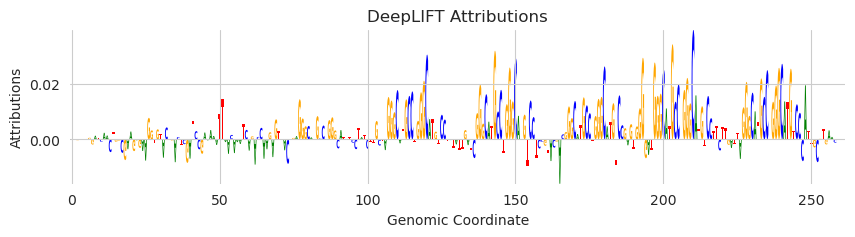

In [49]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[idx, :, :], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions")
plt.show()

In [53]:
# Save ohe seqs as npz
np.savez_compressed(os.path.join(path_log, "valid_ohe.npz"), X.cpu().numpy())
np.savez_compressed(os.path.join(path_log, "valid_shap.npz"), X_attr.cpu().numpy())

In [59]:
%%bash
source activate ml4gland
modisco motifs --help

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


usage: modisco motifs [-h] [-s SEQUENCES] [-a ATTRIBUTIONS] [-i H5PY] -n
                      MAX_SEQLETS [-l N_LEIDEN] [-w WINDOW] [-o OUTPUT] [-v]

optional arguments:
  -h, --help            show this help message and exit
  -s SEQUENCES, --sequences SEQUENCES
                        A .npy or .npz file containing the one-hot encoded
                        sequences.
  -a ATTRIBUTIONS, --attributions ATTRIBUTIONS
                        A .npy or .npz file containing the hypothetical
                        attributions, i.e., the attributions for all
                        nucleotides at all positions.
  -i H5PY, --h5py H5PY  A legacy h5py file containing the one-hot encoded
                        sequences and shap scores.
  -n MAX_SEQLETS, --max_seqlets MAX_SEQLETS
                        The maximum number of seqlets per metacluster.
                      MAX_SEQLETS [-l N_LEIDEN] [-w WINDOW] [-o OUTPUT] [-v]

optional arguments:
  -h, --help            show this help messag

In [60]:
%%bash
source activate ml4gland
modisco motifs -s /cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test/valid_ohe.npz -a /cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test/valid_shap.npz -n 50000 -w 262 -o /cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test/valid_modisco_results.h5

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [62]:
%%bash
source activate ml4gland
modisco report -i /cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test/valid_modisco_results.h5 -o /cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test/valid_modisco_report -s /cellar/users/aklie/data/datasets/Fromel2024_hematopoietic-differentiation_MPRA/models/libA_test/valid_modisco_report -m /cellar/users/aklie/data/ref/motifs/hocomoco_meme.meme

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# DONE!

---